In [5]:
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline

from tqdm import tnrange, tqdm_notebook
from time import sleep

# Setup data location

In [6]:
train_dir = '/datashare/datasets_3rd_party/bdd/bdd100k/images/100k/train'
label_file = '/datashare/datasets_3rd_party/bdd/bdd100k/labels_new/bdd100k_labels_images_train.json'

resize_image = True
image_ext = '.jpg'
#new_w = 800
#new_h = 288
new_w = 1280
new_h = 720
thickness = 8

colors = [(255,0,0),(0,255,0),(0,0,255),
         (255,255,0),(0,255,255),(255,0,255),
         (255,255,255),(0,0,0),
         (127,0,0),(0,127,0),(0,0,127),
         (127,127,0),(0,127,127),(127,0,127),
         (127,127,127),(0,0,0)]

# Loading data and select the first image in the label list to visualize

In [7]:
data = json.load(open(label_file))

In [8]:
def iou(img1, img2, eps=1e-6):
    intersection = (img1 & img2).sum()
    union = (img1 | img2).sum()
    iou = (intersection + eps) / (union + eps)
    return iou

/home/sang/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


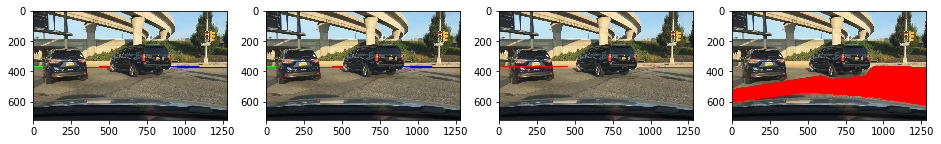

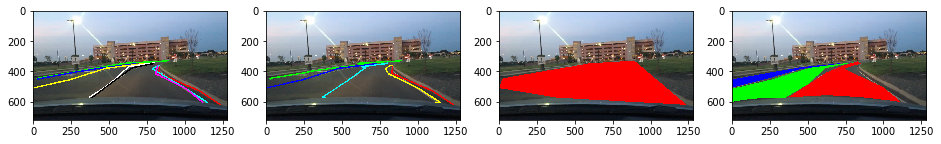

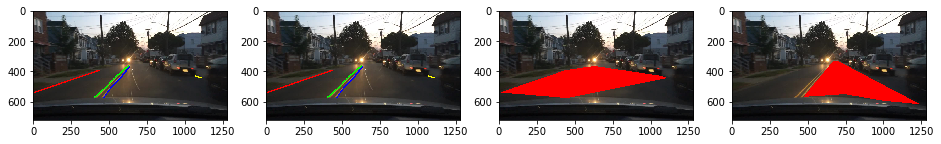

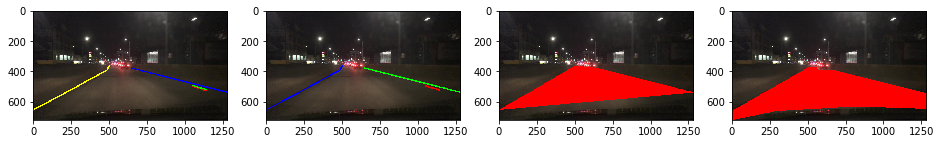

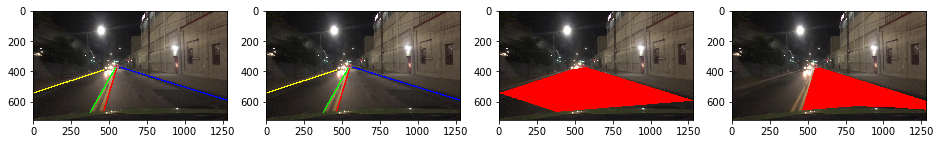

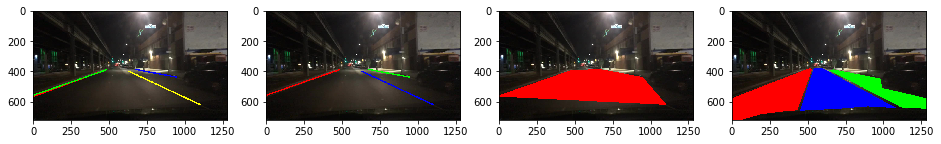

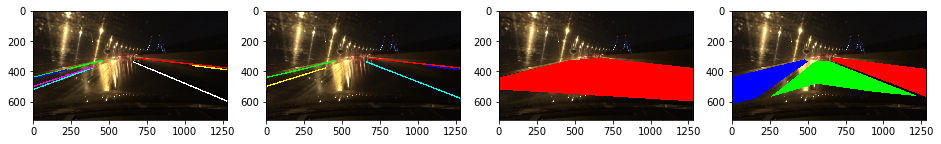

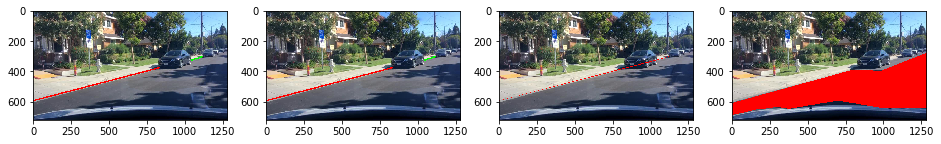

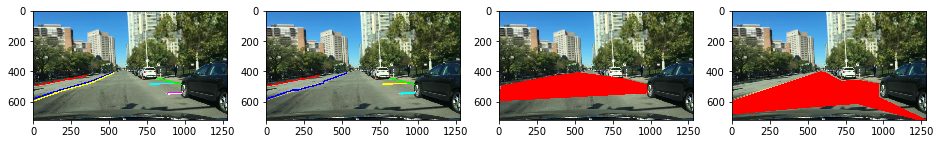

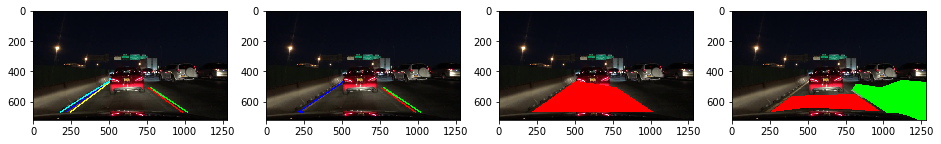

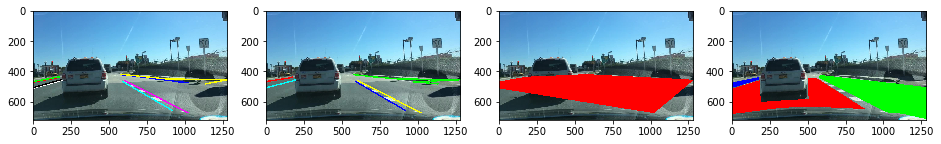

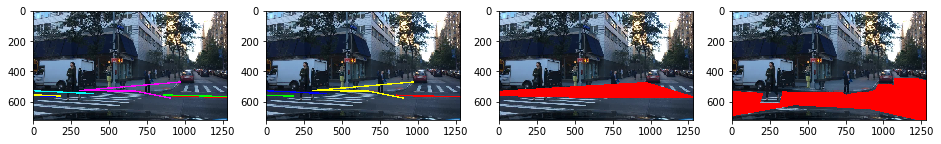

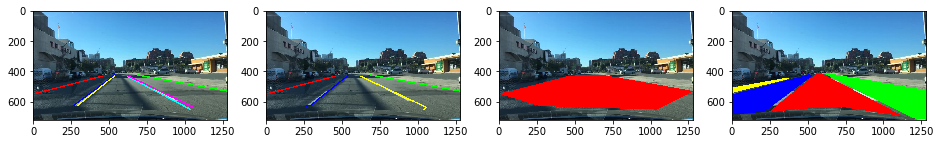

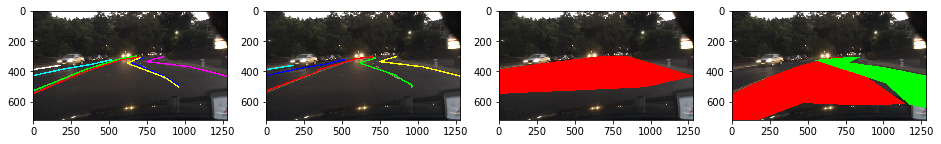

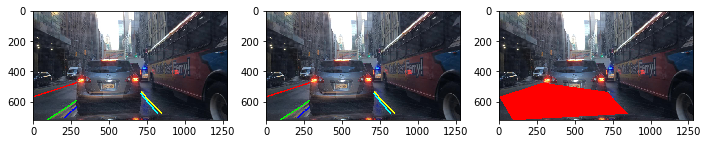

error: OpenCV(3.4.1) /opt/conda/conda-bld/opencv-suite_1527005194613/work/modules/imgproc/src/convhull.cpp:137: error: (-215) total >= 0 && (depth == 5 || depth == 4) in function convexHull


<Figure size 1152x1152 with 0 Axes>

In [10]:
from scipy.spatial import ConvexHull
import itertools

for iter, img_info in enumerate(data):
        
    raw_file = os.path.join(train_dir, img_info['name'])
    lane_labels = [l for l in img_info['labels']
               if l['category'] == 'lane' and l['attributes']['laneDirection'] == 'parallel']
    drivable_labels = [l for l in img_info['labels'] if l['category'] == 'drivable area']
    
    lanes = []
    img = cv2.imread(raw_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    w = img.shape[1] # 1640
    h = img.shape[0] # 590

    x_rate = 1.0 * new_w / w
    y_rate = 1.0 * new_h / h

    if resize_image:
        img = cv2.resize(img, (new_w, new_h))

    for l in lane_labels:
        lane = l['poly2d'][0]['vertices']
        lane = sorted(lane, key=lambda x: x[1])
        lanes.append(lane)

    if resize_image:
        gt_lanes_org = [[(int(x*x_rate), int(y*y_rate)) for (x, y) in lane] for lane in lanes] 
        
    # maximum angle difference threshold to be considered a same line
    method_threshold = -0.2    
    imgs = []
    for lane in lanes:
        # fill the lines so that IoU can be computed!
        tmp_img = np.zeros(shape=[h, w], dtype=np.uint8)
        cv2.polylines(tmp_img, np.int32([lane]), isClosed=False, color=1, thickness=20)
        imgs.append(np.int32(tmp_img))

    # IoU difference between two consecutive (masked) images 
    diffs = [-iou(imgs[i], imgs[i+1]) for i, img in enumerate(imgs[:-1])]

    merge_lanes = []
    line_merged = False
    # merge lanes based on angle differences
    for i,diff in enumerate(diffs):
        if line_merged:
            line_merged = False
            continue
        this_lane = lanes[i]
        if diff < method_threshold:
            # next line will be merged
            this_lane.extend(lanes[i+1])
            line_merged = True    

        this_lane = sorted(this_lane, key=lambda x: x[1])
        merge_lanes.append(this_lane)
        if i == len(diffs)-1 and not line_merged:
            this_lane = sorted(lanes[i+1], key=lambda x: x[1])
            merge_lanes.append(this_lane)

    if resize_image:
        merge_lanes = [[(int(x*x_rate), int(y*y_rate)) for (x, y) in lane] for lane in merge_lanes]
        
    fig=plt.figure(figsize=(16, 16))
    columns = 4
    rows = 1

    # Visualize orginal annotations
    img_vis = img.copy()    
    for i,lane in enumerate(gt_lanes_org):
        fig.add_subplot(rows, columns, 1)
        color_idx = i%len(colors)
        cv2.polylines(img_vis, np.int32([lane]), isClosed=False, color=colors[color_idx], thickness=thickness)
        plt.imshow(img_vis)

    # Visualize merged annotations (lines belong to a same lane are connected)
    img_vis = img.copy()
    for i,lane in enumerate(merge_lanes):
        fig.add_subplot(rows, columns, 2)
        color_idx = i%len(colors)
        cv2.polylines(img_vis, np.int32([lane]), isClosed=False, color=colors[color_idx], thickness=thickness)
        plt.imshow(img_vis)

    # Visualize convex hull of points over all merged lanes
    img_vis = img.copy()
    points = list(itertools.chain.from_iterable(merge_lanes))
    points = np.array(points)
    hull = cv2.convexHull(points, False).squeeze(1)
    fig.add_subplot(rows, columns, 3)
    cv2.fillPoly(img_vis, np.int32([hull]), color=colors[0])
    plt.imshow(img_vis)
        
    img_vis = img.copy()
    for i,lane in enumerate(drivable_labels):
        poly = lane['poly2d'][0]['vertices']
        fig.add_subplot(rows, columns, 4)
        color_idx = i%len(colors)
        cv2.fillPoly(img_vis, np.int32([poly]), color=colors[color_idx])
        plt.imshow(img_vis)
    plt.show()    
    sleep(0.1)